## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [5]:
!pip install nlp

In [6]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.18.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [7]:
import pandas as pd

In [8]:
data = pd.read_pickle("merged_training.pkl")
data.reset_index(drop=True, inplace=True)
data

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love
...,...,...
416804,that was what i felt when i was finally accept...,joy
416805,i take every day as it comes i m just focussin...,fear
416806,i just suddenly feel that everything was fake,sadness
416807,im feeling more eager than ever to claw back w...,joy


In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

# Creating training and validation sets using an 80-20 split
input_train, input_val, target_train, target_val = train_test_split(data.text.to_numpy(),
                                                                    data.emotions.to_numpy(),
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.5)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

train_dataset.head()

,text,class
0,i like frappes and shit when im feeling naught...,love
1,ive had slightly mixed feelings about mebberso...,joy
2,i had no idea what he was thinking all i knew ...,love
3,i have to say im feeling overwhelmed,surprise
4,i also find it interesting that when its looke...,anger


In [10]:
def get_tweet(data):
    tweets = data['text'].tolist()
    labels = data['class'].tolist()
    return tweets, labels

tweets, labels = get_tweet(train_dataset)
tweets[0], labels[0]

('i like frappes and shit when im feeling naughty but i drink tea daily',
 'love')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets)
tokenizer.texts_to_sequences([tweets[0]])

[[2, 14, 1, 4, 845, 34, 17, 8, 706, 20, 2, 1190, 1634, 1024]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

Standardize the length of input sequences so that they are all the same size, which is necessary for neural networks to process them correctly.

- Converts each tweet (text) into a sequence of integers, where each integer represents a word based on the vocabulary learned by the tokenizer

- Padding ensures that all inputs are fixed in size, allowing batch training.

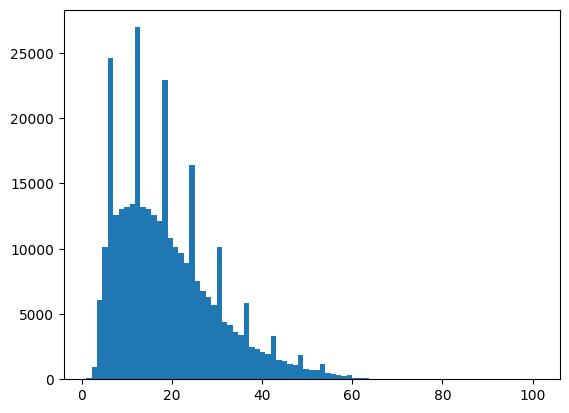

In [13]:
lenghts = [len(tweet.split()) for tweet in tweets]
plt.hist(lenghts, bins=len(set(lenghts)))
plt.show()

In [14]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [15]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded


In [16]:
padded_train = get_sequences(tokenizer, tweets)
padded_train[0]

array([   2,   14,    1,    4,  845,   34,   17,    8,  706,   20,    2,
       1190, 1634, 1024,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

Creates a mapping between text labels and numeric values, which is essential for training machine learning models that operate on numbers.
- It generates two dictionaries: class_to_index, which converts class names to indices, and index_to_class, which does the reverse conversion.
- It then defines a function names_to_ids that transforms a list of text labels into a NumPy array with the corresponding indices. This allows you to represent the labels of the training samples in numeric format, which is necessary for training the model.

In [17]:
classes = set(labels)
print(classes)

{'sadness', 'anger', 'joy', 'fear', 'love', 'surprise'}


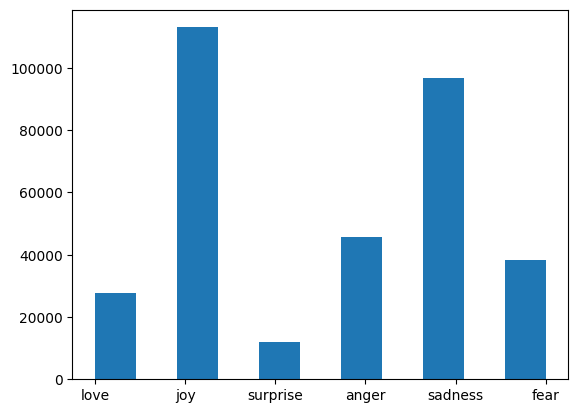

In [18]:
plt.hist(labels, bins=11)
plt.show()

In [19]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [20]:
class_to_index

{'sadness': 0, 'anger': 1, 'joy': 2, 'fear': 3, 'love': 4, 'surprise': 5}

In [21]:
index_to_class

{0: 'sadness', 1: 'anger', 2: 'joy', 3: 'fear', 4: 'love', 5: 'surprise'}

In [22]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])


In [23]:
train_labels = names_to_ids(labels)
print(train_labels[0])

4


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [26]:
val_tweets, val_labels = get_tweet(train_dataset)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [27]:
val_tweets[0], val_labels[0]

('i like frappes and shit when im feeling naughty but i drink tea daily',
 np.int64(4))

In [28]:
h = model.fit(
    padded_train, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 217s 20ms/step - accuracy: 0.8010 - loss: 0.5174 - val_accuracy: 0.9362 - val_loss: 0.1135
Epoch 2/20
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 210s 20ms/step - accuracy: 0.9344 - loss: 0.1160 - val_accuracy: 0.9404 - val_loss: 0.0951
Epoch 3/20
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 238s 18ms/step - accuracy: 0.9397 - loss: 0.0972 - val_accuracy: 0.9415 - val_loss: 0.0903
Epoch 4/20
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 226s 20ms/step - accuracy: 0.9404 - loss: 0.0905 - val_accuracy: 0.9430 - val_loss: 0.0864
Epoch 5/20
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 263s 20ms/step - accuracy: 0.9420 - loss: 0.0872 - val_accuracy: 0.9432 - val_loss: 0.0861
Epoch 6/20
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 262s 20ms/step - accuracy: 0.9432 - loss: 0.0843 - val_accuracy: 0.9438 - val_loss: 0.0840
Epoch 7/20
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 291s 23ms/step - accuracy: 0.9433 - loss: 0.0846 - val_accuracy: 0.9445 - val_loss: 0.0827
Epoch 8/20
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 191s 18ms/s

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

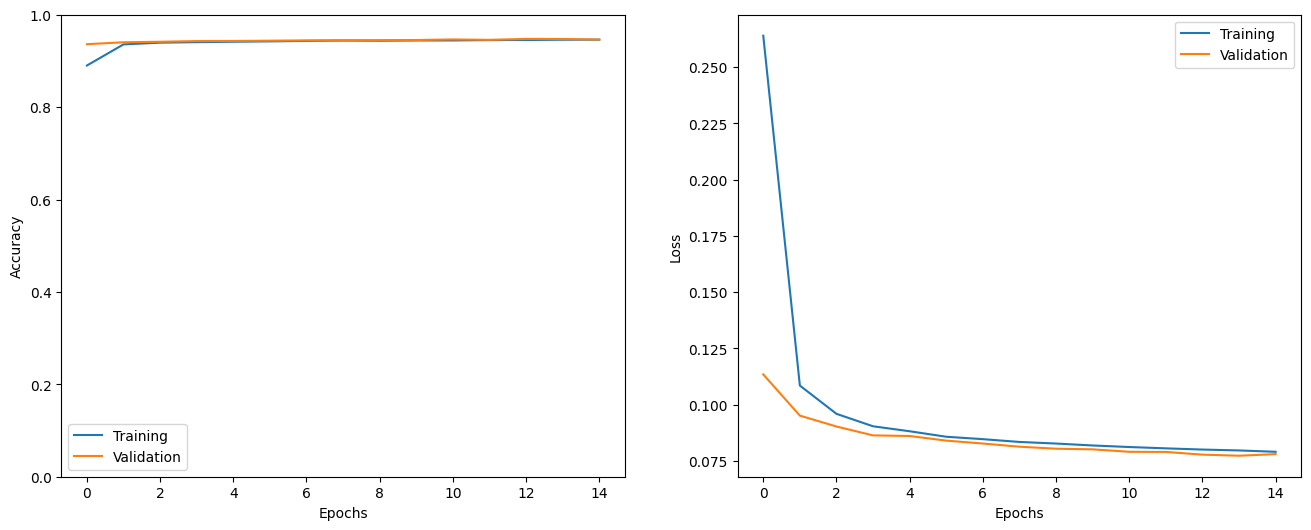

In [29]:
show_history(h)

In [30]:
test_tweets, test_labels = get_tweet(test_dataset)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [31]:
_ = model.evaluate(test_seq, test_labels)

1303/1303 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9370 - loss: 0.1089


In [34]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: i so rarely toss a book into the dnf did not finish category but i found myself losing interest within the first hundred pages and feeling tortured from there on out
Emotion: anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted Emotion: fear


In [35]:
preds = model.predict(test_seq)

1303/1303 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


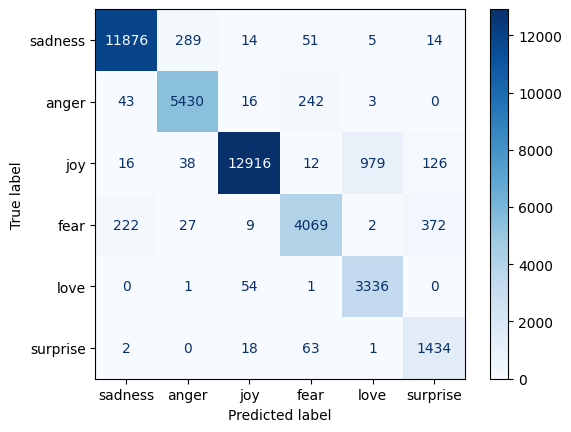

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred_labels = np.argmax(preds, axis=1)
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')